In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - айди
* **age** - возраст преподавателя
* **years_of_experience** - стаж преподавателя
* **lesson_price** - стоимость урока
* **qualification** - квалификация преподавателя
* **physics** - преподает ли физику
* **chemistry** - преподает ли химию
* **biology** - преподает ли биологию
* **english** - преподает ли английский
* **geography** - преподает ли географию
* **history** - преподает ли историю
* **mean_exam_points** - целевое значение, средний балл за экзамен учеников

In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
train_df.shape

(10000, 12)

In [4]:
train_df.head(5)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,61
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,76
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,54
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57


In [5]:
df_full = pd.read_csv('train.csv')

features = ['age', 'years_of_experience', 'lesson_price', 'qualification'] 
target = ['mean_exam_points']

data = np.array(df_full[features])
targets = np.squeeze(np.array(df_full[target]))

df = df_full[features + target]

print(df.shape)

(10000, 5)


In [6]:
def standard_scale(X):
    mean = X.mean()
    std = X.std()
    return (X - mean) / std

In [7]:
for i in range(data.shape[1]):
    data[:, i] = standard_scale(data[:, i])

Реализуем средствами Python алгоритм деревьев решений.

In [8]:
# Разобьем выборку на обучающую и тестовую

#train_data_regr, test_data_regr, train_target_regr, test_target_regr = train_test_split(data, 
#                                                                                        targets, 
#                                                                                        test_size=0.3,
#                                                                                        random_state=1)

In [9]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [10]:
class Leaf_regr:
    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        self.prediction = self.predict()
        
    def predict(self):
        return self.targets.mean()

In [11]:
class BaseTree:

    def __init__(self,
                 max_depth,
                 max_leaf_nodes,
                 min_leaf_samples,
                 leaf_class):
        self.max_depth = max_depth
        self.nodes = []
        self.leaves = []
        self.depth = 0
        self.max_leaves = max_leaf_nodes
        self.min_objects = min_leaf_samples
        self.tree = None
        self.Leaf = leaf_class
        
    # Разбиение датасета в узле
    def split(self,
              data,
              labels,
              column_index,
              t):

        left = np.where(data[:, column_index] <= t)
        right = np.where(data[:, column_index] > t)

        true_data = data[left]
        false_data = data[right]

        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    # Расчет прироста
    def gain(self,
             left_labels,
             right_labels,
             root):

        # доля выборки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return root - p * self.criterion(left_labels) - (1 - p) * self.criterion(right_labels)   
    
    # Нахождение наилучшего разбиения
    def find_best_split(self,
                        data,
                        labels):

        #  обозначим минимальное количество объектов в узле
        min_samples_leaf = 5

        root = self.criterion(labels)

        best_gain = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique(data[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                    continue

                current_gain = self.gain(true_labels, false_labels, root)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_gain > best_gain:
                    best_gain, best_t, best_index = current_gain, t, index

        return best_gain, best_t, best_index
    
    # Построение дерева с помощью рекурсивной функции
    def build_tree(self,
                   data,
                   labels):

        gain, t, index = self.find_best_split(data, labels)
         
        #  Базовый случай 2 - прекращаем рекурсию, когда достигли максимальной глубины дерева
        if self.depth > self.max_depth:
            self.leaves.append(self.Leaf(data, labels))
            return self.Leaf(data, labels)
        
        #  Базовый случай 3 - прекращаем рекурсию, когда достигли максимального количества листьев
        if len(self.leaves) >= self.max_leaves - 1 or self.depth >= self.max_leaves - 1:
            self.leaves.append(self.Leaf(data, labels))
            return self.Leaf(data, labels)
        
        #  Базовый случай 4 - прекращаем рекурсию, когда достигли минимального количества объектов в листе
        if len(data) <= self.min_objects:
            self.leaves.append(self.Leaf(data, labels))
            return self.Leaf(data, labels)
        
         #  Базовый случай 1 - прекращаем рекурсию, когда нет прироста в качества
        if gain == 0:
            self.leaves.append(self.Leaf(data, labels))
            return self.Leaf(data, labels)

        self.depth += 1
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        self.nodes.append(Node(index, t, true_branch, false_branch))
        return Node(index, t, true_branch, false_branch)
    
    def predict_object(self,
                       obj,
                       node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, self.Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.predict_object(obj, node.true_branch)
        else:
            return self.predict_object(obj, node.false_branch)
    
    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels)
        return self
    
    def predict(self, data):
    
        classes = []
        for obj in data:
            prediction = self.predict_object(obj, self.tree)
            classes.append(prediction)
        return classes

In [12]:
class Regression_Tree(BaseTree):
    def __init__(self,
                 max_depth=np.inf,
                 max_leaf_nodes=np.inf,
                 min_leaf_samples=1,
                 leaf_class=Leaf_regr):
        super().__init__(max_depth=max_depth,
                         max_leaf_nodes=max_leaf_nodes,
                         min_leaf_samples=min_leaf_samples,
                         leaf_class=Leaf_regr)

    # Расчет дисперсии
    def criterion(self, targets):
        return np.mean((targets - targets.mean())**2)

Реализуем средствами Python алгоритм градиентного бустинга для деревьев решений.

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.25)

In [14]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
    # было
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    # стало
#    predictions = np.array(
#        sum([eta * alg.predict(X) for alg in trees_list])
#    )
    
    return predictions

В качестве функционала ошибки будем использовать коэффициент детерминации. Реализуем соответствующую функцию.

In [15]:
def my_r2_score(y_real, prediction):
    return 1 - np.sum((np.array(prediction)-np.array(y_real))**2) / np.sum((np.array(y_real)-np.mean(np.array(y_real)))**2)

Используем $L_{2}$ loss $L(y, z) = (y - z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z - y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [16]:
def residual(y, z):
    return - (z - y)

Реализуем функцию обучения градиентного бустинга.

In [17]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = Regression_Tree(max_depth=max_depth)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(my_r2_score(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(my_r2_score(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(my_r2_score(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(my_r2_score(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Построим графики зависимостей коэффициента детерминации от количества деревьев в ансамбле и от максимальной глубины деревьев.

In [18]:
from tqdm import tqdm


eta = 1
max_depths = range(1, 11)


def plot_different_max_depths(n_trees=3, max_depths=max_depths):
    train_errors_depths = []
    test_errors_depths = []

    for max_depth in tqdm(max_depths):
        _, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
        train_errors_depths.append(train_errors[-1])
        test_errors_depths.append(test_errors[-1])


    print(f'Количество деревьев в бустинге {n_trees}')
    plt.plot(range(len(max_depths)), train_errors_depths, label='train_error')
    plt.plot(range(len(max_depths)), test_errors_depths, label='test_error')
    plt.xlabel('Глубина дерева')
    plt.ylabel('R2')
    plt.legend()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.24s/it]


Количество деревьев в бустинге 3


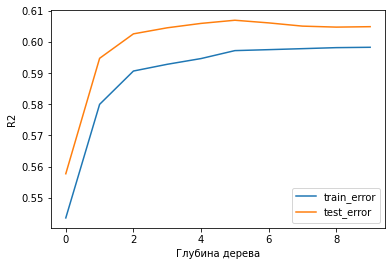

In [19]:
plot_different_max_depths(max_depths=max_depths, n_trees=3)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.66s/it]


Количество деревьев в бустинге 10


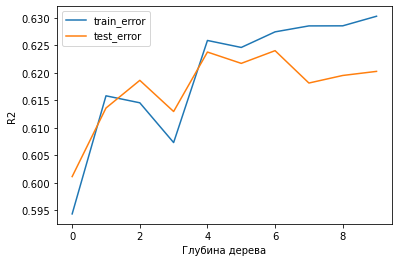

In [20]:
plot_different_max_depths(max_depths=max_depths, n_trees=10)

In [21]:
eta = 1
n_trees = range(1, 50, 5)


def plot_different_num_trees(n_trees=n_trees, max_depth=5):
    train_errors_trees = []
    test_errors_trees = []

    for n in tqdm(n_trees):
        _, train_errors, test_errors = gb_fit(n, max_depth, X_train, X_test, y_train, y_test, eta)
        train_errors_trees.append(train_errors[-1])
        test_errors_trees.append(test_errors[-1])


    print(f'Максимальная глубина дерева {max_depth}')
    plt.plot(n_trees, train_errors_trees, label='train_error')
    plt.plot(n_trees, test_errors_trees, label='test_error')
    plt.xlabel('Количество алгоритмов в бустинге')
    plt.ylabel('R2')
    plt.xticks(n_trees, n_trees)
    plt.legend()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:46<00:00, 46.64s/it]


Максимальная глубина дерева 5


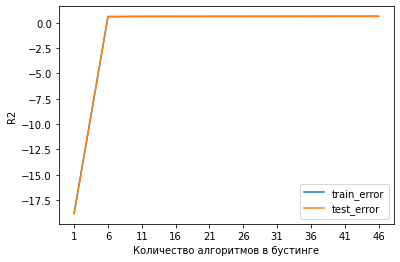

In [22]:
plot_different_num_trees(n_trees=n_trees, max_depth=5)

In [24]:
# Число деревьев в ансамбле
n_trees = 7

# Максимальная глубина деревьев
max_depth = 5

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

In [25]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Коэффициент детерминации из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {my_r2_score(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Коэффициент детерминации из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {my_r2_score(y_test, test_prediction)}')

In [26]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Коэффициент детерминации из 7 деревьев глубиной 5     с шагом 1 на тренировочной выборке: 0.6220521877616509
Коэффициент детерминации из 7 деревьев глубиной 5     с шагом 1 на тестовой выборке: 0.6214834804552635
